# ECE 763 Project 01: Face Detection
## Using the faceScrub dataset

In [1]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import special
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

Global Methods and Variables

In [2]:
# Image size in pixels
img_size = (20,20)

# Create dataset dictionaries
def buildDataset(actors_list):
  img_set = [] # empty list
  for actor in tqdm(actors_list, total=len(actors_list) ,desc='Loading dataset'):
    img0 = {} # empty dictionary
    img1 = {} # empty dictionary
    try:
      # create dictionary and add it to the list
      img0['file'] = actor['0']
      img0['class'] = 0
      img0['image'] = Image.open(actor['0'])
      img_set.append(img0)
      img1['file'] = actor['1']
      img1['class'] = 1
      img1['image'] = Image.open(actor['1'])
      img_set.append(img1)
    except:
      print(actor['name'] + " couldn't be found!")
  return img_set


# Perform whitening to data
def whitening(data):
  eps = 0.0001 # Constant to avoid overflow in division
  mean = sum(data) / len(data)
  std = np.sqrt( sum(np.power( data - mean, 2) ) / len(data) )
  white = (data - mean) / (std + eps)
  return white, mean, std


# Perform dewhitening (Inverse of whitening)
def deWhitening(data, mean, std):
  eps = 0.0001
  inv_white = data * (std+eps) + mean
  return inv_white


# Reshape vector to RGB image
def convertToImage(X, model, mean, std, cov=False):
  img = model.inverse_transform(X)
  img = np.reshape(img, [img_size[0],img_size[1],3])
  img = deWhitening(img, mean, std)
  if cov: # is a covariance vector?
    img = np.sqrt( abs(img) )
  return img.astype(np.uint8)

# Reescale images to range [0,255]
def normImage(img):
  min = img.min()
  max = img.max()
  new_min = 0
  new_max = 255 
  new_img =  (img - min) * ((new_max-new_min) / (max-min)) 
  return new_img.astype(np.uint8)


# Confussion matrix
def plotConfMatrix(X0,X1,TP, FN, TN, FP):
  axis_labels = ["non-face","face",]
  labels = [0]*X0.shape[0] + [1]*X1.shape[0]
  predictions = [0]*TN + [1]*FP + [1]*TP + [0]*FN
  confM = confusion_matrix(labels, predictions)
  fig, ax = plt.subplots(figsize=(7,4)) 
  sns.heatmap(confM, annot=True,cmap="Greens",fmt='g', xticklabels=axis_labels, yticklabels=axis_labels,ax=ax)
  plt.title('Confusion Matrix')
  plt.ylabel('True')
  plt.xlabel('Predicted')

Load datasets into memmory

In [3]:
test_actors = []
train_actors = []

test_file = './data/test/test.txt'
train_file = './data/training/training.txt'

# Read test data
with open(test_file, newline='') as actors:
    actors_reader = csv.DictReader(actors, delimiter='\t')
    for actor in actors_reader:
        test_actors.append(actor)

# Read training data
with open(train_file, newline='') as actors:
    actors_reader = csv.DictReader(actors, delimiter='\t')
    for actor in actors_reader:
        train_actors.append(actor)

# Build datasets
test_set = buildDataset(test_actors)
train_set = buildDataset(train_actors)

Loading dataset: 100%|██████████| 1000/1000 [00:00<00:00, 2861.57it/s]


Apply whitening and PCA transformations to all dataset (test set + train set)

In [4]:
# Retreive faces and non-faces images from all dataset
faces_list = [ np.asfarray(face['image']) for face in test_set+train_set if face['class']==1 ]
nonfaces_list = [ np.asfarray(face['image']) for face in test_set+train_set if face['class']==0 ]

# Apply data whitening transformation
faces_white, face_avg, face_std = whitening(faces_list)
nonfaces_white, nonface_avg, nonface_std = whitening(nonfaces_list)

# Apply PCA transformation
n_cmpts = 10

face_model = PCA(n_components=n_cmpts)
faces_PCA = face_model.fit_transform( np.stack(faces_white).reshape( (len(faces_white), faces_white[0].size) ) ) 

nonface_model = PCA(n_components=n_cmpts)
nonfaces_PCA = nonface_model.fit_transform( np.stack(nonfaces_white).reshape( (len(nonfaces_white), nonfaces_white[0].size) ) )

# Inspect data
print('Face whitening')
print('faces_white:' + str(faces_white.shape) + '  face_avg:' + str(face_avg.shape) + '  face_std:' + str(face_std.shape))
print('Non-face whitening')
print('nonfaces_white:' + str(nonfaces_white.shape) + '  nonface_avg:' + str(nonface_avg.shape) + '  nonface_std:' + str(nonface_std.shape))
print('Face PCA')
print('faces_PCA:' + str(faces_PCA.shape))
print('Non-face PCA')
print('nonfaces_PCA:' + str(nonfaces_PCA.shape))

Face whitening
faces_white:(1100, 20, 20, 3)  face_avg:(20, 20, 3)  face_std:(20, 20, 3)
Non-face whitening
nonfaces_white:(1100, 20, 20, 3)  nonface_avg:(20, 20, 3)  nonface_std:(20, 20, 3)
Face PCA
faces_PCA:(1100, 10)
Non-face PCA
nonfaces_PCA:(1100, 10)


Split pre-process data to create face and non face data matrixes for the test and train set respectively

In [5]:
# Retreive pre-processed test and training datasets
face_test_size = len([face for face in test_set if face['class']==1])
nonface_test_size = len([face for face in test_set if face['class']==0])

X1_test = faces_PCA[:face_test_size,:]
X1_train = faces_PCA[face_test_size-1:-1,:]

X0_test = nonfaces_PCA[:nonface_test_size,:]
X0_train = nonfaces_PCA[nonface_test_size-1:-1,:]

# Inspect data
print('Face data')
print('X1_train:' + str(X1_train.shape) + '  X1_test:' + str(X1_test.shape))
print('Non-face data')
print('X0_train:' + str(X0_train.shape) + '  X0_test:' + str(X0_test.shape))

Face data
X1_train:(1000, 10)  X1_test:(100, 10)
Non-face data
X0_train:(1000, 10)  X0_test:(100, 10)


# Single Multivariate Gaussian Model

Methods SMG Model

In [6]:
def probSMG(X, mu, sigma):
    dim = len(mu.ravel())
    prob_2pi = -dim/2 * np.log(2*math.pi)
    prob_sigma = -1/2*np.sum(np.log(sigma),where=(sigma>0))
    prob_mean = -1/2 * np.sum(np.power( X-mu ,2) / sigma,axis=1)
    prob = np.exp(prob_2pi + prob_sigma + prob_mean)
    return prob


def logProbSMG(X, mu, sigma):
    dim = len(mu.ravel())
    log_2pi = -dim / 2*np.log(2*math.pi)
    log_sigma = -1/2 * np.sum(np.log(sigma), where=(sigma>0))
    log_mu = -1/2 * np.sum( np.power(X-mu,2) / sigma, axis=1)
    log_prob = log_2pi + log_sigma + log_mu
    return log_prob


def fitSMG(X):
    num_data = X.shape[0]
    mu = np.sum(X,axis=0) / num_data
    sigma = np.zeros( [1, X[0].size] )
    for i in range(num_data):
        x = X[i]
        sigma += np.power(x-mu,2)
    sigma = sigma / num_data
    return mu, sigma


def predictSMG(X, label, mean, sigma, threshold):
    num_data = X.shape[0]
    num_class = len(mean)
    log_prob = np.zeros([num_class,num_data])
    for i in range(num_class):
        log_prob[i,:] = logProbSMG(X, mean[i], sigma[i])  
    prob = np.exp(log_prob)    
    norm_prob = prob[1,:] / (prob[1,:] + prob[0,:])
    num_true = sum( ( norm_prob>=threshold ) == label )
    num_false = num_data - num_true
    return num_true, num_false

Compute sample mean vector and sample covariance matrix and visualize the estimated mean and covariance matrix for face and non-face respectively

[None, None, None, None]

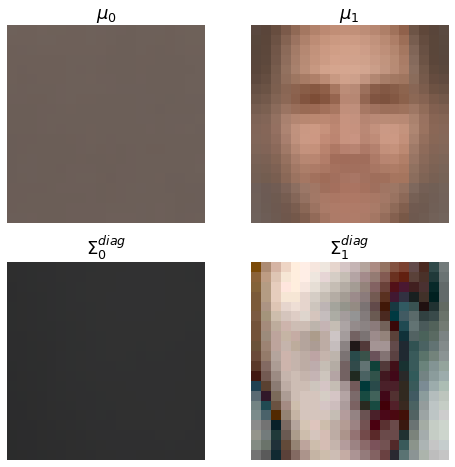

In [7]:
# Emtpy lists
mu_SMG = [None,None] # Mean
sigma_SMG = [None,None] # Covariance 

# Train model
mu_SMG[0] ,sigma_SMG[0] = fitSMG(X0_train)
mu_SMG[1] ,sigma_SMG[1] = fitSMG(X1_train)

# Convert vectors to images
mu0_SMG_image = convertToImage(mu_SMG[0], nonface_model, nonface_avg, nonface_std)
mu1_SMG_image = convertToImage(mu_SMG[1], face_model, face_avg, face_std)

sigma0_SMG_image = convertToImage(sigma_SMG[0], nonface_model, nonface_avg, nonface_std, cov=True)
sigma1_SMG_image = convertToImage(sigma_SMG[1], face_model, face_avg, face_std, cov=True)

# Plot code
fig, axes = plt.subplots(2,2, figsize=(8,8))
[axi.axis('off') for axi in axes.flat] # hide axis

axes[0,1].imshow(mu1_SMG_image)
axes[0,1].set_title(r'$\mu_1$')
axes[0,0].imshow(mu0_SMG_image)
axes[0,0].set_title(r'$\mu_0$')
axes[1,0].imshow(sigma0_SMG_image)
axes[1,0].set_title(r'$\Sigma_0^{diag}$')
axes[1,1].imshow(normImage(sigma1_SMG_image))
axes[1,1].set_title(r'$\Sigma_1^{diag}$')
[axi.title.set_fontsize(18) for axi in axes.flat]

Evaluate the learned model on the testing images using 0.5 as threshold for the posterior. Compute False Positive Rate (FPR), False Negative Rate (FNR) and the missclasification rate (MR).

False Positive Rate   :  0.16
False Negative Rate   :  0.17
Misclassification Rate:  0.165


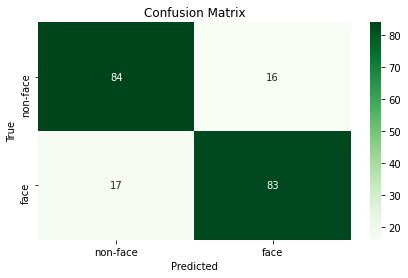

In [8]:
threshold = 0.5 # detection threshold

TP_SMG, FN_SMG = predictSMG( X1_test, np.ones(X1_test.shape[0]), mu_SMG, sigma_SMG, threshold)
TN_SMG, FP_SMG = predictSMG( X0_test, np.zeros(X0_test.shape[0]), mu_SMG, sigma_SMG, threshold)

# Compute rates
FPR = FP_SMG / (FP_SMG+TN_SMG)
FNR = FN_SMG / (TP_SMG+FN_SMG)
MR = (FP_SMG + FN_SMG) / (X0_test.shape[0] + X1_test.shape[0])

# Print results
print("False Positive Rate   : ",round(FPR,3))
print("False Negative Rate   : ",round(FNR,3))
print("Misclassification Rate: ",round(MR,3))

# Confussion matrix
plotConfMatrix(X0_test,X1_test,TP_SMG, FN_SMG, TN_SMG, FP_SMG)

ROC curve

Text(0.5, 1.0, 'ROC Curve Simple Gaussian Model')

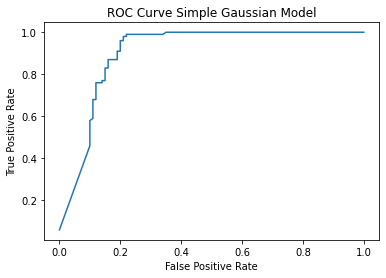

In [9]:
plt.figure()
steps = 1000
plt_SMG_FPR = np.zeros(steps)
plt_SMG_TPR = np.zeros(steps)
for i in range(0,steps):
    threshold = i/(steps-1)
    TP, FN = predictSMG( X1_test, np.ones(X1_test.shape[0]), mu_SMG, sigma_SMG, threshold)
    TN, FP = predictSMG( X0_test, np.zeros(X0_test.shape[0]), mu_SMG, sigma_SMG, threshold)
    plt_SMG_FPR[i] = FP / (FP+TN) 
    plt_SMG_TPR[i] = 1 - FN / (FN+TP)
plt.plot(plt_SMG_FPR,plt_SMG_TPR)
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate") 
plt.title("ROC Curve Simple Gaussian Model")

# Mixture of Multivariate Gaussian Model

Methods MoG Model

In [10]:
min_log = -30

def logProbMoG(X, lmbd, mu, sigma):
    eps = 0.0001 # To avoid division by 0
    dim = len(mu.ravel())
    log_lambda = np.log(lmbd + eps)
    log_prob = sum(log_lambda)+sum(logProbSMG(X, mu+eps, sigma+eps))
    return log_prob


def probMoG(X, lmbd, mu, sigma):
    num_mix = lmbd.size
    num_data = X.shape[0]
    prob_M = np.zeros([num_mix,num_data])
    for i in range(num_mix):
        prob_M[i,:] = lmbd[i] * probSMG(X,mu[i,:], sigma[i,:])
    prob = np.sum(prob_M,axis=0)
    return prob


def fitMoG(X, num_mix, max_iter):
    eps = 0.0001 # To avoid division by 0
    # Generating random Lambda
    L = np.random.rand(num_mix)
    lmbd = L/sum(L)
    # Generating random mu and sigma vectors
    size_X = X.shape[1]
    num_data = X.shape[0]
    mu = (np.random.rand(num_mix, size_X)-0.5)*2
    sigma = np.random.rand(num_mix, size_X)
    # EM Algorithm
    for j in range(max_iter):
        # Calculating matrix Rij
        prob_MoG = np.zeros([num_mix, num_data])
        for i in range (num_mix):
            # Verifying Non Empty Elements
            mask_lmbd = (lmbd[i]>0)
            # Calculing p(x|h=lambda)
            prob_MoG[i,:] = np.log(lmbd[i],where=mask_lmbd) \
            + logProbSMG(X, mu[i,:], sigma[i,:])    
        # Normalizing Rij by columns (lambda,num_data)
        max_log = np.amax(prob_MoG, axis=0) # Maximum Log Probability
        sub_log = (prob_MoG - max_log)
        prob = np.exp(sub_log) * ((sub_log)>min_log)
        sum_prob = np.sum(prob, axis=0)
        Rij = np.divide(prob, (sum_prob + eps))
        # Update Rule for lambdas
        sum_Rij = np.sum(Rij,axis=1)
        new_lmbd = sum_Rij/(sum(sum_Rij)+eps)
        # Update Rule for Mean Vectors
        new_mu = np.zeros([num_mix, size_X])
        for i in range (num_mix):
            sum_Rij_mu = (X.T * Rij[i,:]).T
            new_mu[i,:] = sum(sum_Rij_mu) / (sum(Rij[i,:])+eps)
        # Update Rule for Covariance Vectors
        new_sigma = np.zeros([num_mix,size_X])
        for i in range (num_mix):
            RijCov=np.power(X-new_mu[i],2)
            sum_Rij_sigma=(RijCov.T*Rij[i,:]).T
            new_sigma[i,:]=sum(sum_Rij_sigma) / (sum(Rij[i,:])+eps)
        # Update parameters
        lmbd = new_lmbd
        mu = new_mu + eps
        sigma = new_sigma + eps
    return new_lmbd, new_mu, new_sigma


def predictMoG(X,label, lmbd, mu, sigma, threshold):
    eps = 0.0001
    num_data = X.shape[0]
    num_class = len(mu)
    prob = np.zeros([num_class, num_data]) # Rows = Classes, Columns = Data Points
    # Calculing log-probabilities over all classes and data points
    for i in range(num_class):
        prob[i,:] = probMoG(X, lmbd[i], mu[i], sigma[i])
    norm_prob = np.power((1+prob[0,:]/prob[1,:]),-1)
    num_true = sum((norm_prob>=threshold)==label)
    num_false = num_data - num_true
    return num_true,num_false

Compute sample mean vector and sample covariance matrix and visualize the estimated mean and covariance matrix for face and non-face respectively

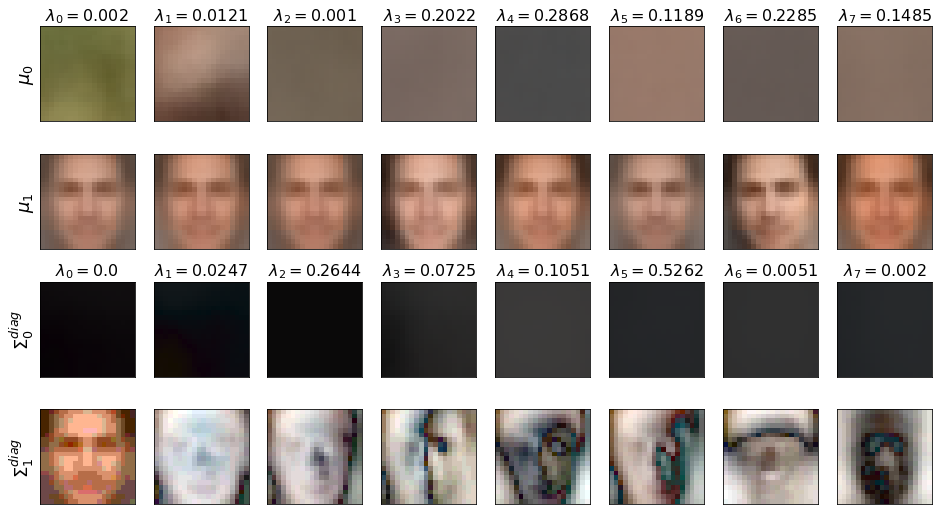

In [23]:
n_mixtures = 8
max_iterations = 15

# Emtpy lists
mu_MoG = [None,None] # Mean
sigma_MoG = [None,None] # Covariance
lambda_MoG = [None,None] # Weights

# Train model
lambda_MoG[0], mu_MoG[0] ,sigma_MoG[0] = fitMoG(X0_train,n_mixtures, max_iterations)
lambda_MoG[1], mu_MoG[1] ,sigma_MoG[1] = fitMoG(X1_train,n_mixtures,max_iterations)

# Plot code
fig, axes = plt.subplots(4,n_mixtures, figsize=(16,9))
[axi.xaxis.set_ticks([]) for axi in axes.flat] # hide X ticks
[axi.yaxis.set_ticks([]) for axi in axes.flat] # hide X ticks

for i in range(8):
    # Convert vectors to images
    mu0 = convertToImage(mu_MoG[0][i], nonface_model, nonface_avg, nonface_std)
    mu1 = convertToImage(mu_MoG[1][i], face_model, face_avg, face_std)
    sigma0  = convertToImage(sigma_MoG[0][i], nonface_model, nonface_avg, nonface_std, cov=True)
    sigma1  = convertToImage(sigma_MoG[1][i], face_model, face_avg, face_std, cov=True)
    axes[0,i].imshow(mu0)
    axes[1,i].imshow(mu1)
    axes[2,i].imshow(sigma0)
    axes[3,i].imshow(normImage(sigma1))
    axes[0,i].set_title('$\lambda_{}={}$'.format(i,round(lambda_MoG[0][i],4)))
    axes[2,i].set_title('$\lambda_{}={}$'.format(i,round(lambda_MoG[1][i],4)))
[axi.title.set_fontsize(16) for axi in axes.flat]

axes[0,0].set_ylabel(r'$\mu_{0}$')
axes[1,0].set_ylabel(r'$\mu_{1}$')
axes[2,0].set_ylabel(r'$\Sigma_{0}^{diag}$')
axes[3,0].set_ylabel(r'$\Sigma_{1}^{diag}$')
[axi.yaxis.label.set_fontsize(18) for axi in axes.flat];

Evaluate the learned model on the testing images using 0.5 as threshold for the posterior. Compute False Positive Rate (FPR), False Negative Rate (FNR) and the missclasification rate (MR)

False Positive Rate   :  0.15
False Negative Rate   :  0.06
Misclassification Rate:  0.105


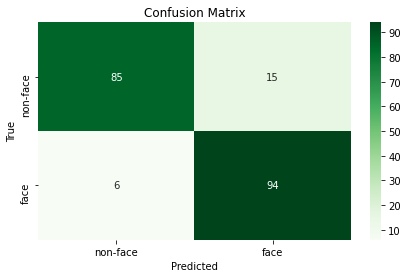

In [12]:
threshold = 0.5 # detection threshold

TP_MoG, FN_MoG = predictMoG( X1_test, np.ones(X1_test.shape[0]), lambda_MoG, mu_MoG, sigma_MoG, threshold)
TN_MoG, FP_MoG = predictMoG( X0_test, np.zeros(X0_test.shape[0]), lambda_MoG, mu_MoG, sigma_MoG, threshold)

# Compute rates
FPR = FP_MoG / (FP_MoG+TN_MoG)
FNR = FN_MoG / (TP_MoG+FN_MoG)
MR = (FP_MoG + FN_MoG) / (X0_test.shape[0] + X1_test.shape[0])

# Print results
print("False Positive Rate   : ",round(FPR,3))
print("False Negative Rate   : ",round(FNR,3))
print("Misclassification Rate: ",round(MR,3))

# Confussion matrix
plotConfMatrix(X0_test,X1_test,TP_MoG, FN_MoG, TN_MoG, FP_MoG)

ROC curve

Text(0.5, 1.0, 'ROC Curve Mixture of Gaussian Model')

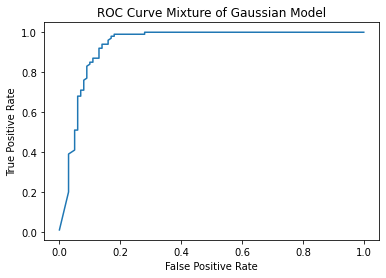

In [13]:
plt.figure()
steps = 1000
plt_MoG_FPR = np.zeros(steps)
plt_MoG_TPR = np.zeros(steps)
for i in range(0,steps):
    threshold = i/(steps-1)
    TP, FN = predictMoG( X1_test, np.ones(X1_test.shape[0]), lambda_MoG, mu_MoG, sigma_MoG, threshold)
    TN, FP = predictMoG( X0_test, np.zeros(X0_test.shape[0]), lambda_MoG, mu_MoG, sigma_MoG, threshold)
    plt_MoG_FPR[i] = FP / (FP+TN) 
    plt_MoG_TPR[i] = 1 - FN / (FN+TP)
plt.plot(plt_MoG_FPR,plt_MoG_TPR)
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate") 
plt.title("ROC Curve Mixture of Gaussian Model")

# t-distribution Model

 Methods t-distribution model

In [14]:
max_v = 0.1


def logProbTDist(X, mu, sigma, v):
    dim = len(mu.ravel())
    log_gam1 = np.log(math.gamma((v+dim)/2))
    log_2pi = -dim/2 * np.log(v * math.pi)
    log_sigma = -1/2 * np.sum(np.log(sigma), where=(sigma>0))
    log_gam2 = -np.log(math.gamma(v/2))
    log_mu = -1/2 * (v+dim) * np.log(1 + np.sum(np.power(X - mu,2) / sigma, axis=1) / v)
    log_prob = log_gam1 + log_2pi + log_sigma + log_gam2 + log_mu
    return log_prob


def vCalculation(v, _Ehi, _ElogHi):    
    it = 0
    I = _Ehi.size
    while(it<20 or err>0.0001):
        f = I/2 * np.log(v/2) - I/2 * special.polygamma(0,v/2) \
            - sum(_Ehi)/2+sum(_ElogHi)/2+I/2
        df = I/(2*v) - I/4 * special.polygamma(1,v/2)
        new_v = v - f/df
        err = abs(new_v - v)/1.0
        v = new_v
        it += 1
    return v


def fitTDist(X, max_iter):
    # Generating random mu and sigma vectors (sigma diagonal)
    size_X = X.shape[1]
    mu = (np.random.rand(size_X)-0.5)*2
    sigma = np.random.rand(size_X)
    # Generating random v
    v = max_v #np.random.rand(1)*maxValueV
    # EM Algorithm
    for j in range(max_iter):
        # Solving E[hi]
        mulMeanCov = np.sum(np.power(X-mu,2)/sigma,axis=1)
        E_hi = (v + size_X)/(v + mulMeanCov)
        # Solving E[log(hi)]
        psiHi = special.digamma((v + size_X)/2)
        E_logHi = psiHi - np.log((v + mulMeanCov)/2)
        # Update rule mu
        new_mu = np.dot(X.T,E_hi)/np.sum(E_hi)
        # Update rule sigma vector
        powDiffMean = np.power(X-mu,2)
        new_sigma = np.dot(powDiffMean.T,E_hi)/np.sum(E_hi)
        # Update rule v Value
        new_v = vCalculation(v, E_hi, E_logHi)
        # Update Parameters
        mu = new_mu
        sigma = new_sigma
        v = new_v 
    return new_mu, new_sigma, new_v


def predictTDist(X, label, mu, sigma, v, threshold):
    num_data = X.shape[0]
    num_class = len(mu)
    log_prob = np.zeros([num_class,num_data])
    # Calculating log-probabilities over all classes and data points
    for i in range(num_class):
        log_prob[i,:] = logProbTDist(X, mu[i], sigma[i], v[i])
    prob = np.exp(log_prob)
    norm_prob = prob[1,:]/(prob[1,:]+prob[0,:])
    num_true = sum((norm_prob>=threshold)==label)
    num_false = num_data - num_true
    return num_true,num_false

Compute sample mean vector and sample covariance matrix and visualize the estimated mean and covariance matrix for face and non-face respectively

[None, None, None, None]

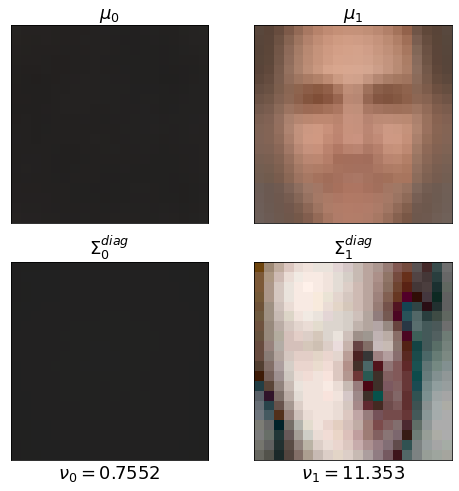

In [15]:
max_iterations = 25

# Emtpy lists
mu_TDist = [None,None] # Mean
sigma_TDist = [None,None] # Covariance
v_TDist = [None,None] # Degrees of Freedom

# Train model
mu_TDist[0], sigma_TDist[0], v_TDist[0] = fitTDist(X0_train, max_iterations)
mu_TDist[1], sigma_TDist[1], v_TDist[1] = fitTDist(X1_train, max_iterations)

# Convert vectors to images
mu0_img = convertToImage(mu_TDist[0], nonface_model, nonface_avg, nonface_std)
mu1_img = convertToImage(mu_TDist[1], face_model, face_avg, face_std)
sigma0_img  = convertToImage(sigma_TDist[0], nonface_model, nonface_avg, nonface_std, cov=True)
sigma1_img  = convertToImage(sigma_TDist[1], face_model, face_avg, nonface_std, cov=True)

# Plot code
fig, axes = plt.subplots(2,2, figsize=(8,8))
[axi.xaxis.set_ticks([]) for axi in axes.flat] # hide X ticks
[axi.yaxis.set_ticks([]) for axi in axes.flat] # hide Y ticks
axes[0,0].imshow(mu0_img)
axes[0,1].imshow(mu1_img)
axes[1,0].imshow(sigma0_img)
axes[1,1].imshow(normImage(sigma1_img))
axes[0,1].set_title(r'$\mu_1$')
axes[0,0].set_title(r'$\mu_0$')
axes[1,0].set_title(r'$\Sigma_0^{diag}$')
axes[1,1].set_title(r'$\Sigma_1^{diag}$')
axes[1,0].set_xlabel(r'$\nu_{}={}$'.format( 0,round(v_TDist[0],4) ) )
axes[1,1].set_xlabel(r'$\nu_{}={}$'.format( 1,round(v_TDist[1],4) ) )
[axi.title.set_fontsize(18) for axi in axes.flat]
[axi.xaxis.label.set_fontsize(18) for axi in axes.flat]

Evaluate the learned model on the testing images using 0.5 as threshold for the posterior. Compute False Positive Rate (FPR), False Negative Rate (FNR) and the missclasification rate (MR)

False Positive Rate   :  0.23
False Negative Rate   :  0.0
Misclassification Rate:  0.115


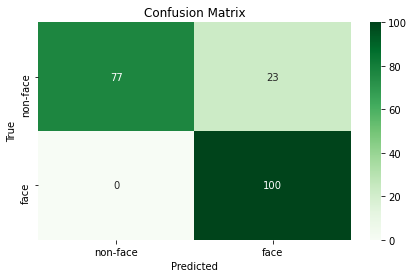

In [16]:
threshold = 0.5 # detection threshold

TP_TDist, FN_TDist = predictTDist(X1_test, np.ones(X1_test.shape[0]),mu_TDist,sigma_TDist,v_TDist,threshold)
TN_TDist, FP_TDist = predictTDist(X0_test, np.zeros(X0_test.shape[0]), mu_TDist,sigma_TDist,v_TDist, threshold)

# Compute rates
FPR = FP_TDist / (FP_TDist+TN_TDist)
FNR = FN_TDist / (TP_TDist+FN_TDist)
MR = (FP_TDist + FN_TDist) / (X0_test.shape[0] + X1_test.shape[0])

# Print results
print("False Positive Rate   : ",round(FPR,3))
print("False Negative Rate   : ",round(FNR,3))
print("Misclassification Rate: ",round(MR,3))

# Confussion Matrix
plotConfMatrix(X0_test,X1_test,TP_TDist, FN_TDist, TN_TDist, FP_TDist)

ROC curve

Text(0.5, 1.0, 'ROC Curve t-Distribution Model')

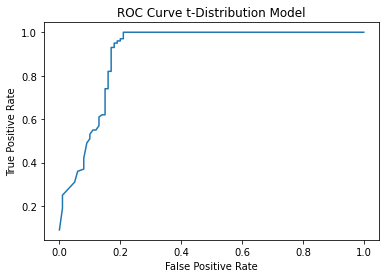

In [17]:
# Plot ROC Curve
plt.figure()
steps = 1000
plt_TDist_FPR = np.zeros(steps)
plt_TDist_TPR = np.zeros(steps)
for i in range(steps):
    threshold = i/steps
    TP, FN = predictTDist(X1_test, np.ones(X1_test.shape[0]), mu_TDist,sigma_TDist,v_TDist,threshold)
    TN, FP = predictTDist(X0_test, np.zeros(X0_test.shape[0]), mu_TDist,sigma_TDist,v_TDist, threshold)
    plt_TDist_FPR[i] = FP / (FP+TN) 
    plt_TDist_TPR[i] = 1 - FN / (FN+TP)
plt.plot(plt_TDist_FPR, plt_TDist_TPR)
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate") 
plt.title("ROC Curve t-Distribution Model")

# Factor Analysis Model

Methods Factor Analysis Model

In [18]:
def probFA(X, mu, sigma, phi):
    num_data = X.shape[0]
    dim = mu.size
    prob = np.zeros(num_data)
    covM = np.linalg.multi_dot([phi,phi.T]) + sigma
    p2pi = np.power(2 * math.pi, -dim/2)
    pDet = np.power(np.linalg.det(covM), -1/2)
    invCovM = np.linalg.inv(covM)
    for i in range(num_data):
        expP = np.exp(-1/2 * np.linalg.multi_dot([(X[i,:] - mu).T, invCovM, (X[i,:] - mu)]))
        prob[i] = pDet * p2pi * expP
    return prob


def fitFA(X, size_phi, max_iter):
    # Generating random Mean and Covariance Vectors
    sizeVector = X.shape[1]
    num_data = X.shape[0]
    mu = (np.random.rand(sizeVector)-0.5)*2 # Range [-1,1]
    sigma = np.diag(np.random.rand(sizeVector)) # Range [0,1] 
    # Generating random Covariance Matrix (Phi Matrix)
    phi = np.random.rand(sizeVector,size_phi)
    for iter in range(max_iter):
        # Solving E[hi]
        diff = (X - mu)
        I = np.identity(size_phi)
        # Change
        inv_sigma = np.linalg.inv(sigma)
        phi_temp = np.linalg.inv(np.linalg.multi_dot([phi.T,inv_sigma,phi])+I) 
        E_hi = np.dot(np.linalg.multi_dot([phi_temp,phi.T,inv_sigma]),diff.T) # columns = E[hi], rows = data
        # Solving E[hi.hi^T]
        E_hi_hi_T = []
        for i in range(num_data):
            E_hi_hi_T.append(phi_temp + np.outer(E_hi[:,i],E_hi[:,i]))
        # Update rule mean
        new_mu = np.sum(X,axis=0)/num_data
        # Update rule phi
        invsumEhihiT = np.linalg.inv(sum(E_hi_hi_T))
        diff = (X - new_mu) # Rows = Data, Columns = num_data
        sumDiffEhi = np.zeros([sizeVector,size_phi])
        for i in range(num_data):
            sumDiffEhi = sumDiffEhi + np.outer(diff[i,:],E_hi[:,i])
        new_phi = np.dot(sumDiffEhi,invsumEhihiT)
        # Update rule Covariance Matrix
        sumDiagVector = np.zeros(sizeVector)
        diagVector1 = np.power(diff,2)
        for i in range (num_data):
            phiEhi_Vector = np.dot(new_phi,E_hi[:,i].T)*diff[i,:]
            diagVector = diagVector1[i,:]-phiEhi_Vector
            sumDiagVector = sumDiagVector + diagVector
        new_sigma = np.diag(sumDiagVector/num_data)
        # Update Parameters
        mu = new_mu
        phi = new_phi
        sigma = new_sigma
    return new_mu, new_phi, new_sigma


def predictFA(X, label, mu, sigma, phi, threshold):
    num_data = X.shape[0]
    num_class = len(mu)
    prob = np.zeros([num_class,num_data]) # (classes, Data_Points)
    # Calculating probabilities over all classes and data points
    for i in range(num_class):
        prob[i,:] = probFA(X, mu[i], sigma[i], phi[i])
    norm_prob = prob[1,:]/(prob[1,:]+prob[0,:])
    num_true = sum((norm_prob>=threshold)==label)
    num_false = num_data - num_true
    return num_true, num_false

Compute sample mean vector and sample covariance matrix and visualize the estimated mean and covariance matrix for face and non-face respectively

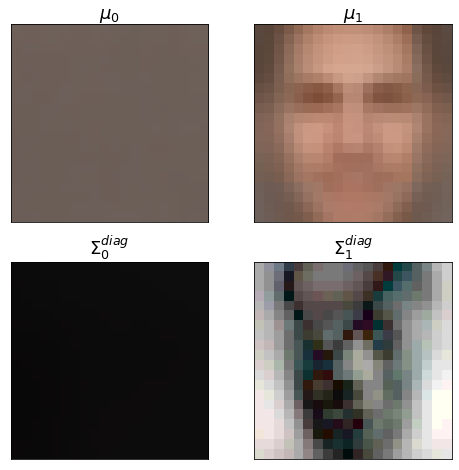

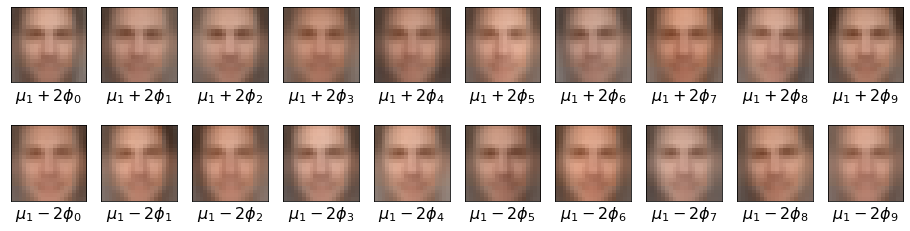

In [19]:
max_iterations = 15
size_phi = 10 # number of factors

# Emtpy lists
mu_FA = [None,None] # Mean
sigma_FA = [None,None] # Covariance
phi_FA = [None,None] # Factors

# Train model
mu_FA[0], phi_FA[0], sigma_FA[0] = fitFA(
    X0_train, size_phi, max_iterations)
mu_FA[1], phi_FA[1], sigma_FA[1] = fitFA(
    X1_train, size_phi, max_iterations)

# Convert vectors to images
mu0_img = convertToImage(mu_FA[0], nonface_model, nonface_avg, nonface_std)
mu1_img = convertToImage(mu_FA[1], face_model, face_avg, face_std)
sigma0_img  = convertToImage(sigma_FA[0].diagonal(), nonface_model, nonface_avg, nonface_std, cov=True)
sigma1_img  = convertToImage(sigma_FA[1].diagonal(), face_model, face_avg, nonface_std, cov=True)

# Plot code
fig, axes = plt.subplots(2,2, figsize=(8,8))
[axi.xaxis.set_ticks([]) for axi in axes.flat] # hide X ticks
[axi.yaxis.set_ticks([]) for axi in axes.flat] # hide Y ticks

axes[0,0].imshow(mu0_img)
axes[0,1].imshow(mu1_img)
axes[1,0].imshow(sigma0_img)
axes[1,1].imshow(normImage(sigma1_img))
axes[0,1].set_title(r'$\mu_1$')
axes[0,0].set_title(r'$\mu_0$')
axes[1,0].set_title(r'$\Sigma_0^{diag}$')
axes[1,1].set_title(r'$\Sigma_1^{diag}$')
[axi.title.set_fontsize(18) for axi in axes.flat]

# Show mean variation by adding/substracting the factor analyzers
C = 2 # factor constant coefficient
fig, axes = plt.subplots(2,size_phi, figsize=(16,4))
[axi.xaxis.set_ticks([]) for axi in axes.flat] # hide X ticks
[axi.yaxis.set_ticks([]) for axi in axes.flat] # hide Y ticks
for i in range(size_phi):
    mu_pphi_img = convertToImage(mu_FA[1]+phi_FA[1][:,i], face_model, face_avg, face_std)
    mu_mphi_img = convertToImage(mu_FA[1]-phi_FA[1][:,i], face_model, face_avg, face_std)
    axes[0,i].imshow(mu_pphi_img)
    axes[1,i].imshow(mu_mphi_img)
    axes[0,i].set_xlabel( r'$\mu_1+{}\phi_{}$'.format(C,i) )
    axes[0,i].xaxis.label.set_fontsize(16)
    axes[1,i].set_xlabel( r'$\mu_1-{}\phi_{}$'.format(C,i) )
    axes[1,i].xaxis.label.set_fontsize(16)

Evaluate the learned model on the testing images using 0.5 as threshold for the posterior. Compute False Positive Rate (FPR), False Negative Rate (FNR) and the missclasification rate (MR)

False Positive Rate   :  0.18
False Negative Rate   :  0.14
Misclassification Rate:  0.16


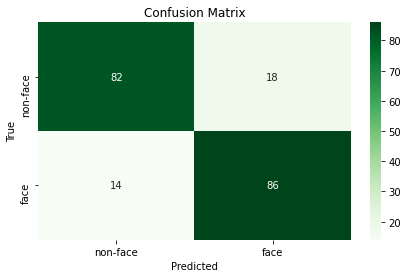

In [20]:
threshold = 0.5 # detection threshold

TP_FA, FN_FA =  predictFA(X1_test, np.ones(X1_test.shape[0]), mu_FA, sigma_FA, phi_FA, threshold)
TN_FA, FP_FA =  predictFA(X0_test, np.zeros(X0_test.shape[0]), mu_FA, sigma_FA, phi_FA, threshold)

# Compute rates
FPR = FP_FA / (FP_FA+TN_FA)
FNR = FN_FA / (TP_FA+FN_FA)
MR = (FP_FA + FN_FA) / (X0_test.shape[0] + X1_test.shape[0])

# Print results
print("False Positive Rate   : ",round(FPR,3))
print("False Negative Rate   : ",round(FNR,3))
print("Misclassification Rate: ",round(MR,3))

# Confussion Matrix
plotConfMatrix(X0_test,X1_test,TP_FA, FN_FA, TN_FA, FP_FA)

ROC curve

Text(0.5, 1.0, 'ROC Curve Factor Analysis Model')

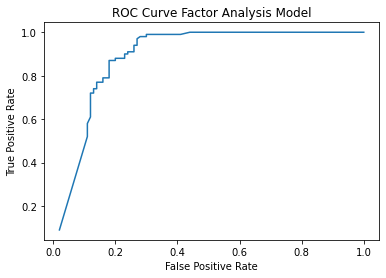

In [21]:
# Plot ROC Curve
plt.figure()
steps = 1000
plt_FA_FPR = np.zeros(steps)
plt_FA_TPR = np.zeros(steps)
for i in range(steps):
    threshold = i/(steps-1)
    TP, FN =  predictFA(X1_test, np.ones(X1_test.shape[0]), mu_FA, sigma_FA, phi_FA, threshold)
    TN, FP =  predictFA(X0_test, np.zeros(X0_test.shape[0]), mu_FA, sigma_FA, phi_FA, threshold)
    plt_FA_FPR[i] = FP / (FP+TN)
    plt_FA_TPR[i] = 1 - FN / (FN+TP)
plt.plot(plt_FA_FPR,plt_FA_TPR)
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate") 
plt.title("ROC Curve Factor Analysis Model")